# Duke Capacity Payments

## Goal
Model payments due to heat pump and heat pump water heater energy savings for homes in Duke Energy Carolina's NC territory under the utility's capacity payment rate structure. RA is involved in a program with Duke Energy and Google, where Google is hoping to leverage the Duke’s proposed time-varying capacity payments to help pay for heat pump/heat pump water heater installs in electric resistance homes in territory. We wish to compute an estimate of the per household and overall potential capacity payments for such a program.


## Assumptions
- Universe of households: Single family, owner-occupied electric resistannce heated homes in Duke Energy Carolina's territory in North Carolina,according to 2024.2 ResStock. One important caveat is that this is a slight overestimate of the number of households since we include all qualifying households in any county that Duke Energy Carolina's serves in NC according to [EIA Form 861](https://www.eia.gov/electricity/data/eia861/), when in reality, [a handful of these counties are also served by Duke Energy Progress](https://ieefa.org/wp-content/uploads/2021/07/2021-07-06-IEEFA-Duke-Energy-territory-map-360x216-v3.jpg) . 
- Upgrades: Medium Efficiency Heat Pump and Heat Pump Water Heater. We do not assume any load shifting for the water heater. 
- Capacity Payment Rate: [Schedule Purchange Power (NC) According to Docket No. E-100, Sub 194](https://rewiringamerica.atlassian.net/browse/RAT-216?focusedCommentId=10486&page=com.atlassian.jira.plugin.system.issuetabpanels%3Acomment-tabpanel#comment-10486), according to the Interconnected to Distribution, Two-Year Fixed Rate. This calculation includes only positive energy savings.


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas.tseries.holiday as holiday
from pandas.tseries.offsets import Day
import pathlib
import pyspark.sql.functions as F
import seaborn as sns
import sys

from IPython.display import display, HTML

sys.path.append("../../src")

from rates.rate_widgets import RateScheduleWidget
from rates.rate_structure import RateSchedule
from rates.modeled_rate import ModeledRateWithWeekendHoliday
from rates.utility_selector_functions import create_electric_utility_widget, select_county_geoids_in_utility

pd.options.display.float_format = '{:,.0f}'.format

In [0]:
n_partitions = 600
spark.conf.set("spark.sql.shuffle.partitions", str(n_partitions))  # Balanced for 16 nodes
spark.conf.set("spark.sql.adaptive.enabled", "true")   # Auto-optimize

In [0]:
DUKE_CAPACITY_PAYMENT_RATE_STRUCTURE_FPATH = pathlib.Path() / "duke_capacity_payment_structure.json"

In [0]:
BASELINE_UPGRADE_ID = 0.01
HP_UPGRADE_ID = 11.07
HPWH_UPGRADE_ID = 17.02
BUILDING_SET_2024 = 'ResStock 2024.2'
RESSTOCK_2024_WEIGHT = 252.3

## Define Geography of Interest



In [0]:
# Create widget for selecting electric utility, in this case pre-populated with correct values
# so this notebook can run without intervention, but in most cases can widget call with no args
selector = create_electric_utility_widget(state_default='NC', utility_default = 'Duke Energy Carolinas, LLC')

In [0]:
# Counties that  serves in NC according for EIA Form 861 for 2023
duke_nc_county_geoids = select_county_geoids_in_utility(selector)

Counties in Duke Energy Carolinas, LLC: ['ALAMANCE', 'ALEXANDER', 'ANSON', 'BUNCOMBE', 'BURKE', 'CABARRUS', 'CALDWELL', 'CASWELL', 'CATAWBA', 'CHATHAM', 'CHEROKEE', 'CLAY', 'CLEVELAND', 'DAVIDSON', 'DAVIE', 'DURHAM', 'FORSYTH', 'GASTON', 'GRAHAM', 'GRANVILLE', 'GUILFORD', 'HENDERSON', 'IREDELL', 'JACKSON', 'LINCOLN', 'MACON', 'MCDOWELL', 'MECKLENBURG', 'ORANGE', 'PERSON', 'POLK', 'RANDOLPH', 'ROCKINGHAM', 'ROWAN', 'RUTHERFORD', 'STANLY', 'STOKES', 'SURRY', 'SWAIN', 'TRANSYLVANIA', 'UNION', 'WAKE', 'WILKES', 'YADKIN']


## Pull in Load Profiles

In [0]:
# Filter the metadata to buildings of interest (not considering baseline appliance fuels)
base_metadata = (
    spark.table("building_model.resstock_metadata_2024_2")
    .where(F.col("county_geoid").isin(duke_nc_county_geoids))
    .where(F.col("in_geometry_building_type_acs").startswith("Single"))
    .where(~F.col("in_is_vacant"))
    .where(~F.col("in_is_rented"))
    .where(~F.col("in_hvac_heating_appliance_type").isin(["ASHP", "MSHP"]))
)

# Filter to ER heating only for hp upgrades, ER water heating only for hpwh upgrades and include both for baseline. We will apply each filter to the relevant upgrade's load profiles
hp_metadata = base_metadata.where(F.col("in_heating_fuel") == "Electricity")
hpwh_metadata = base_metadata.where(F.col("in_water_heater_fuel") == "Electricity")
baseline_metadata = base_metadata.where((F.col("in_heating_fuel") == "Electricity") | (F.col("in_water_heater_fuel") == "Electricity"))


In [0]:
date_cols = ["month", "day", "hour"]
# Filter baseline and load profles to relevant buildings
baseline = (
    spark.table("building_model.resstock_ra_outputs_hourly")
    .where(F.col("upgrade_id") == BASELINE_UPGRADE_ID)
    .where(F.col("building_set") == BUILDING_SET_2024)
    # Note: Filtering by county when reading the hourly data (before the join) makes
    # this much faster, because many input files can be skipped over entirely.
    .where(F.col("county_geoid").isin(duke_nc_county_geoids))
    .join(
        F.broadcast(  # broadcast since this is a relatively small table of <1000 rows
            baseline_metadata.select("building_id")
        ),
        "building_id",
    )
    .repartition(n_partitions, "building_id")  # Improves join performance
    .select("building_id", *date_cols, F.col("out_electricity_total_energy_consumption_kwh").alias("baseline_kwh"))
)

hp_upgrades = (
    spark.table("building_model.resstock_ra_outputs_hourly")
    .where(F.col("upgrade_id") == HP_UPGRADE_ID)
    .where(F.col("building_set") == BUILDING_SET_2024)
    .where(F.col("county_geoid").isin(duke_nc_county_geoids))
    .join(F.broadcast(hp_metadata.select("building_id")), "building_id")
    .repartition(n_partitions, "building_id")
    .select(
        "building_id",
        "upgrade_id",
        *date_cols,
        F.col("out_electricity_total_energy_consumption_kwh").alias("upgrade_kwh")
    )
)

hpwh_upgrades = (
    spark.table("building_model.resstock_ra_outputs_hourly")
    .where(F.col("upgrade_id") == HPWH_UPGRADE_ID)
    .where(F.col("building_set") == BUILDING_SET_2024)
    .where(F.col("county_geoid").isin(duke_nc_county_geoids))
    .join(F.broadcast(hpwh_metadata.select("building_id")), "building_id")
    .repartition(n_partitions, "building_id")
    .select(
        "building_id",
        "upgrade_id",
        *date_cols,
        F.col("out_electricity_total_energy_consumption_kwh").alias("upgrade_kwh")
    )
)

# Union the upgrades, join with baseline, and compute positive savings
building_load_profiles = (
    hp_upgrades.union(hpwh_upgrades)
    .join(baseline, ["building_id", *date_cols])
    .withColumn("electricity_kwh", F.greatest(F.col("baseline_kwh") - F.col("upgrade_kwh"), F.lit(0)))
    .select("building_id", "upgrade_id", *date_cols, "electricity_kwh")
)

In [0]:
# Load into memory
load_profiles_pd = building_load_profiles.select(
    "building_id",
    "upgrade_id",
    *date_cols,
    "electricity_kwh"
).toPandas()

## Define Rates

Define the time varying rate structure if hasn't been saved to to file

**NOTE: If rate structure has already been saved, can proceed directly to Next Section: Calculate Payments**

In [0]:
# Set up a new rate schedule.
widget = RateScheduleWidget()

In [0]:
# write rate schedule to file if it doesnt already exist
if not DUKE_CAPACITY_PAYMENT_RATE_STRUCTURE_FPATH.exists():
    with DUKE_CAPACITY_PAYMENT_RATE_STRUCTURE_FPATH.open("w") as f:
        elec_e_schedule = widget.get_rate_schedule()
        elec_e_schedule.to_json_file(DUKE_CAPACITY_PAYMENT_RATE_STRUCTURE_FPATH)
else:
    print(f"{DUKE_CAPACITY_PAYMENT_RATE_STRUCTURE_FPATH} already exists")
     

duke_capacity_payment_structure.json already exists


## Calculate Payments


In [0]:
# Read in Duke Capacity Payment Rate: see details in this Ticket https://rewiringamerica.atlassian.net/browse/RAT-216?focusedCommentId=10486&page=com.atlassian.jira.plugin.system.issuetabpanels%3Acomment-tabpanel#comment-10486
schedule = RateSchedule.from_json_file(DUKE_CAPACITY_PAYMENT_RATE_STRUCTURE_FPATH)
display(HTML(schedule.schedule_html))

In [0]:
# define special holidays according to rate structure which deviates from the defauly NERC holidays
class DukeEnergyHolidays(holiday.AbstractHolidayCalendar):
    """NERC (North American Electric Reliability Corporation) Holiday Calendar."""

    rules = [
        holiday.Holiday("New Year's Day", month=1, day=1, observance=holiday.nearest_workday),
        holiday.GoodFriday,
        holiday.USMemorialDay,
        holiday.Holiday("Independence Day", month=7, day=4, observance=holiday.nearest_workday),
        holiday.USLaborDay,
        holiday.USThanksgivingDay,
        holiday.Holiday(
            "Day After Thanksgiving", 
            month=11, 
            day=1, 
            offset=[holiday.USThanksgivingDay.offset, Day(1)],  # Thanksgiving + 1 day
            start_date="1970-01-01",  # Ensures it works for all dates
        ),
        holiday.Holiday("Christmas Day", month=12, day=25, observance=holiday.nearest_workday),
    ]

In [0]:
# model payments under heat pump upgrade
model_hp = ModeledRateWithWeekendHoliday(
    name='Duke Capacity Payment',
    load_profile_df = load_profiles_pd[load_profiles_pd.upgrade_id == HP_UPGRADE_ID],
    rate_schedule=schedule,
    holiday_calendar=DukeEnergyHolidays()
)

# model payments under heat pump water heater upgrade
model_hpwh = ModeledRateWithWeekendHoliday(
    name='Duke Capacity Payment',
    load_profile_df = load_profiles_pd[load_profiles_pd.upgrade_id == HPWH_UPGRADE_ID],
    rate_schedule=schedule,
    holiday_calendar=DukeEnergyHolidays()
)

In [0]:
# Combine payments by (building, month, hour) into single convenient dataframe for analyis
df = pd.concat(
    [
        model_hp.to_long_format(granularity="monthly_hourly", upgrade_id=HP_UPGRADE_ID),
        model_hpwh.to_long_format(granularity="monthly_hourly", upgrade_id=HPWH_UPGRADE_ID),
    ]
)

# lets rename the default col name in this case since its a payment not a cost
df.rename({"cost": "payment", "cost_daily_mean": "payment_daily_mean"}, axis=1, inplace=True)

# add back metadata that we may want to group by
metadata_cols = ["in_area_median_income", "in_water_heater_fuel", "in_hvac_cooling_type", "in_vintage"]
building_metadata = baseline_metadata.select("building_id", *metadata_cols).toPandas()
building_metadata["building_id"] = building_metadata["building_id"].astype(int)
df_w_metadata = df.merge(building_metadata, on="building_id")

## Results!

### Annual And Lifetime Energy Savings & Payments

,count,mean,std,min,25%,50%,75%,max
upgrade_id,,,,,,,,
11,796,435,261,42,257,369,543,"1,977"
17,"2,055",86,54,15,46,70,110,421


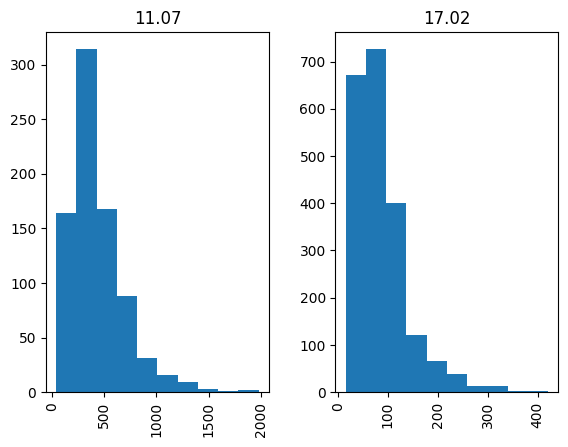

In [0]:
#calculate annual payments
annual_capacity_payments = df_w_metadata.groupby(["building_id", "upgrade_id", *metadata_cols], as_index=False).agg({'payment': 'sum', 'energy': 'sum'})
annual_capacity_payments.hist('payment', by = 'upgrade_id')
annual_capacity_payments.groupby('upgrade_id').payment.describe()

In [0]:
# calculate payments over lifetime of appliance and over all households
annual_capacity_payments['appliance_lifetime'] = annual_capacity_payments.upgrade_id.apply(
        lambda x: 10 if x == HPWH_UPGRADE_ID else 15
    )
annual_capacity_payments['lifetime_payment'] = annual_capacity_payments.payment * annual_capacity_payments.appliance_lifetime

def household_count(x):
    return len(x) * RESSTOCK_2024_WEIGHT

def total_all_households(x):
    return sum(x) * RESSTOCK_2024_WEIGHT


annual_capacity_payments.groupby('upgrade_id').agg(
    {
        "lifetime_payment": [total_all_households, "mean", "median"], 
        "payment": [total_all_households, "mean", "median"],
        "energy": [total_all_households, "mean", "median"],
        "building_id": ["count", household_count]
    }
)

lifetime_payment               ... energy building_id                
           total_all_households  mean median  ... median       count household_count
upgrade_id                                    ...                                   
11                1,310,599,055 6,526  5,534  ...  8,696         796         200,831
17                  443,761,324   856    702  ...  1,765        2055         518,476

[2 rows x 11 columns]

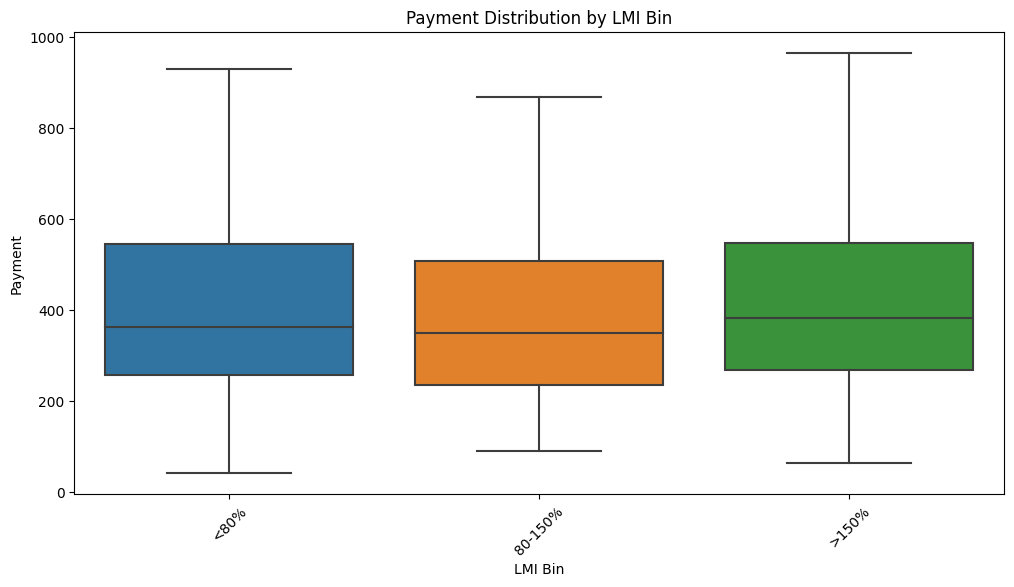

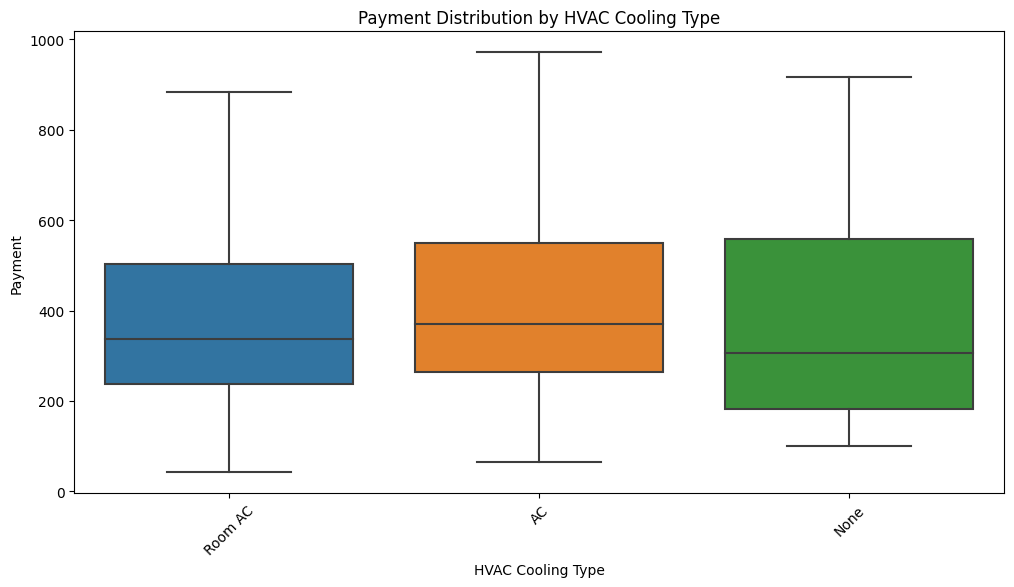

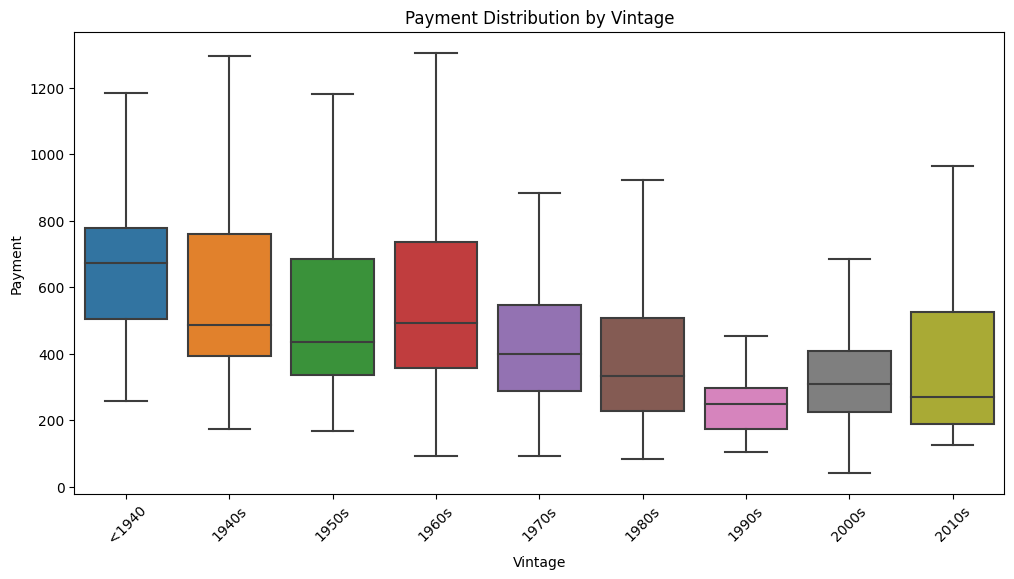

In [0]:
# Plot boxplots of heat pump payments by income category and by cooling type
# (looks like the hpwh payments are pretty minimal without load shifting so lets just focus on hp for now)
def plot_payment_boxplot(data, x_col, title, xlabel, order=None, figsize=(12, 6)):
    """
    Plots a boxplot of payments by specified category
    
    Parameters:
    - data: DataFrame containing the data
    - x_col: Column name to group by on x-axis
    - title: Plot title
    - xlabel: Label for x-axis
    - order: Optional ordering of categories
    - figsize: Figure size (default (12,6))
    """
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=data,
        x=x_col,
        y='payment',
        order=order, 
        showfliers=False
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Payment')
    plt.xticks(rotation=45)
    plt.show()


def ami_to_lmi_bins(in_area_median_income):
    if in_area_median_income == '150%+':
        return '>150%'
    elif in_area_median_income in ['80-100%', '100-120%']:
        return '80-150%'
    else:
        return '<80%'

annual_capacity_payments['lmi_bin'] = annual_capacity_payments.in_area_median_income.apply(ami_to_lmi_bins)

# Plot payment by income category
plot_payment_boxplot(
    data=annual_capacity_payments[annual_capacity_payments.upgrade_id==HP_UPGRADE_ID],
    x_col='lmi_bin',
    title='Payment Distribution by LMI Bin',
    xlabel='LMI Bin',
    order=['<80%', '80-150%', '>150%']
)

# Plot payment by cooling type
plot_payment_boxplot(
    data=annual_capacity_payments[annual_capacity_payments.upgrade_id==HP_UPGRADE_ID],
    x_col='in_hvac_cooling_type',
    title='Payment Distribution by HVAC Cooling Type',
    xlabel='HVAC Cooling Type'
)

income_order = ['0-30%', '30-60%', '60-80%', '80-100%', '100-120%', '120-150%', '150%+']
# Plot payment by vintage
plot_payment_boxplot(
    data=annual_capacity_payments[annual_capacity_payments.upgrade_id==HP_UPGRADE_ID],
    x_col='in_vintage',
    title='Payment Distribution by Vintage',
    xlabel='Vintage',
    order=sorted(annual_capacity_payments.in_vintage.unique())
)

### Hourly and Seasonanal Payment Trends

### Schedule Plots

This provides one way to look at when the highest payments are happening, and how this results from the interactions bewtween the rate structure and the energy savings trends.

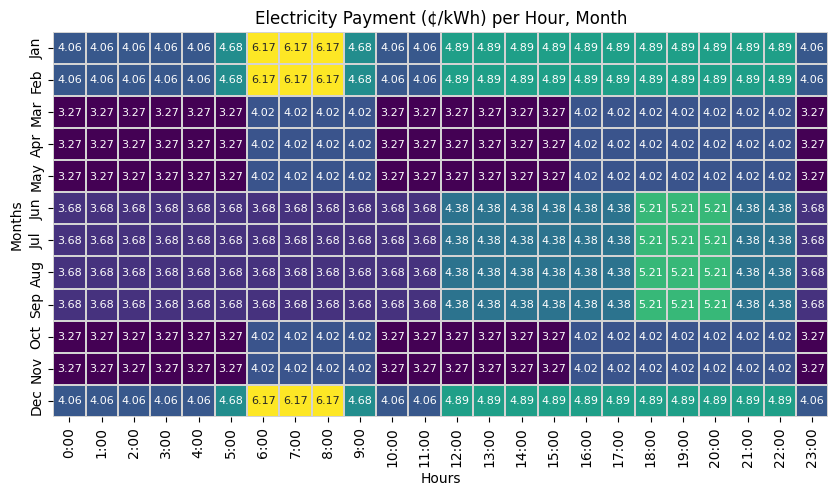

In [0]:
# lets first visualize at the time varying rates in a more grockable format
fig = model_hp.plot_matrix_by_month_hour(model_hp.rate_matrix*100, plot_title = "Electricity Payment (¢/kWh) per Hour, Month", n_decimal_places=2)

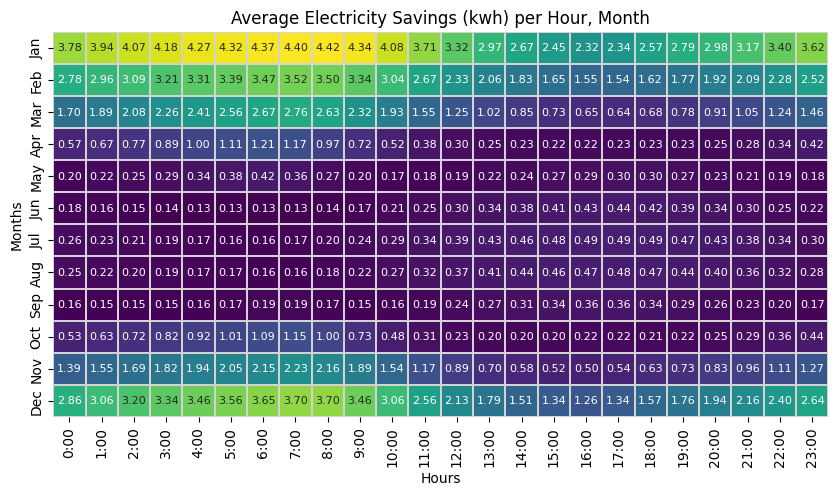

In [0]:
# Then lets see the average energy savings by hour and month
fig = model_hp.plot_matrix_by_month_hour(np.mean(np.mean(model_hp.load_profile_matrix, axis = -1), axis=0), plot_title = "Average Electricity Savings (kwh) per Hour, Month")

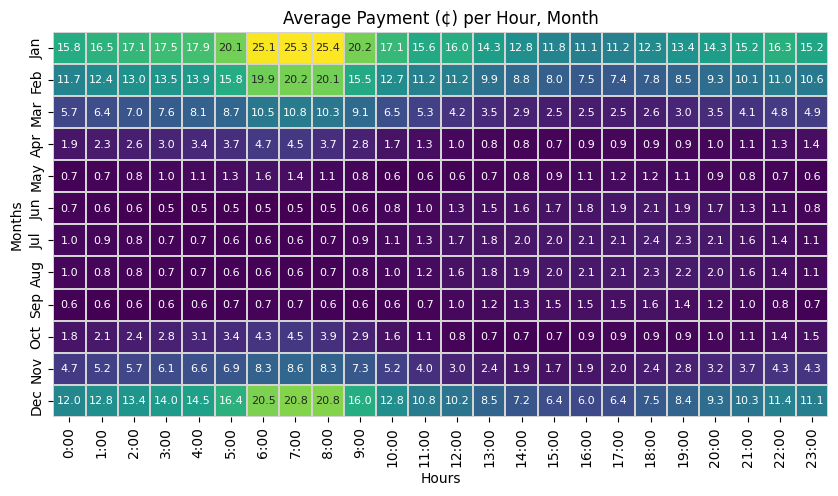

In [0]:
# and finally lets look at how the two come together to get the average payment per month and hour:
# looks like the peak winter payments are really paying off, whereas the savings in summer are marginal enough that even during peak the payment is pretty minimal
fig = model_hp.plot_matrix_by_month_hour(np.mean(model_hp.bills_by_building_month_hour/30*100, axis = 0), plot_title = "Average Payment (¢) per Hour, Month", n_decimal_places = 1)

### Line Plots

This provides an alternate way to look at the same thing, and more clearly look at the correlation between payment trends and energy savings trends, and how this differs by season. 

In [0]:
# Define seasons
def get_season(month):
    if month in [6, 7, 8, 9]:  # June-Sept
        return 'Summer'
    elif month in [12, 1, 2]:  # Dec-Feb
        return 'Winter'
    else:  # Mar-May, Oct-Nov
        return 'Shoulder'
    
# Define season colors for plotting
SEASON_COLORS = {'Winter': 'tab:blue', 'Shoulder': 'tab:green', 'Summer': 'tab:red'}

# Add season column
df_w_metadata['season'] = df_w_metadata['month'].apply(get_season)

In [0]:
def plot_mean_energy_and_payment_load_profiles_by_season(df):
    # Aggregate by season and hour for energy and payment
    daily_energy = df.groupby(['season', 'hour'])['energy_daily_mean'].mean().reset_index()
    daily_payment = df.groupby(['season', 'hour'])['payment_daily_mean'].mean().reset_index()

    plt.figure(figsize=(12, 6))

    # Create twin axes
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Define consistent styles
    energy_style = {'linestyle': '-', 'marker': 'o'}
    payment_style = {'linestyle': '--', 'marker': 's'}


    # Plot all energy first (left axis)
    for season in ['Winter', 'Shoulder', 'Summer']:
        s_energy = daily_energy[daily_energy['season'] == season]
        ax1.plot(s_energy['hour'], s_energy['energy_daily_mean'], 
                color=SEASON_COLORS[season],
                **energy_style)

    # Then plot all payment (right axis)
    for season in ['Winter', 'Shoulder', 'Summer']:
        s_payment = daily_payment[daily_payment['season'] == season]
        ax2.plot(s_payment['hour'], s_payment['payment_daily_mean'], 
                color=SEASON_COLORS[season],
                **payment_style)

    # Formatting
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Energy Savings (kWh)', color='black')
    ax2.set_ylabel('Payment ($)', color='black')
    ax1.grid(True)

    # Create simplified legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', **energy_style, label='Energy Savings'),
        Line2D([0], [0], color='black', **payment_style, label='Payment'),
        *[Line2D([0], [0], color=color, label=season) 
        for season, color in SEASON_COLORS.items()]
    ]

    ax1.legend(handles=legend_elements, loc='upper left')

    plt.title('Mean Energy Savings (-) vs Payment (--) Load Shapes by Season')
    plt.tight_layout()
    plt.show()

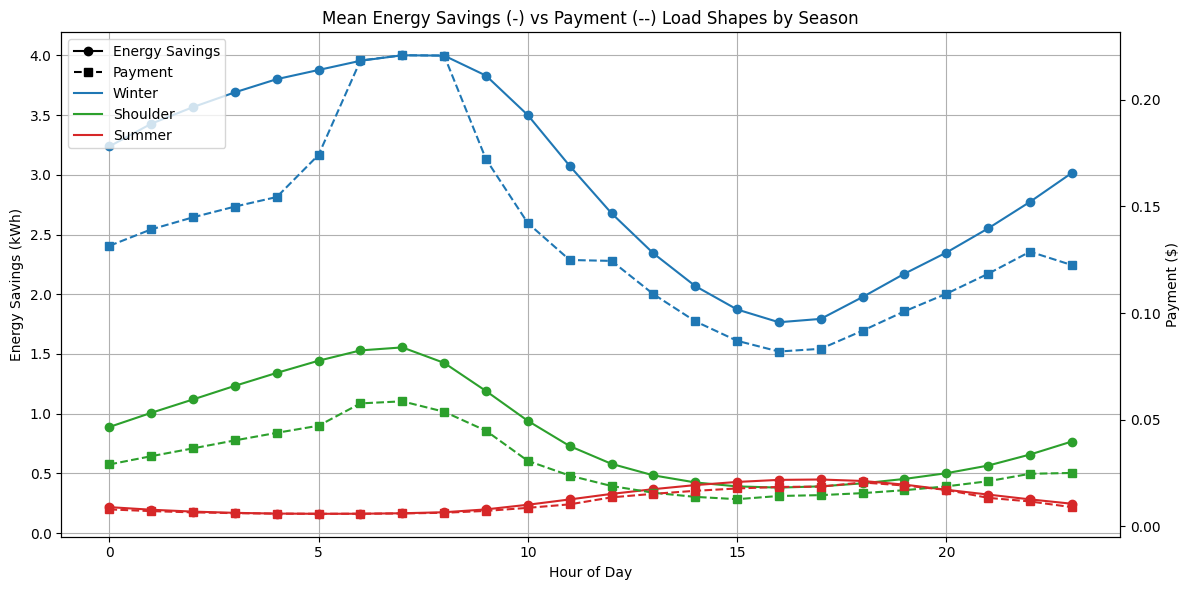

In [0]:
plot_mean_energy_and_payment_load_profiles_by_season(df_w_metadata[df_w_metadata.upgrade_id==HP_UPGRADE_ID].copy())

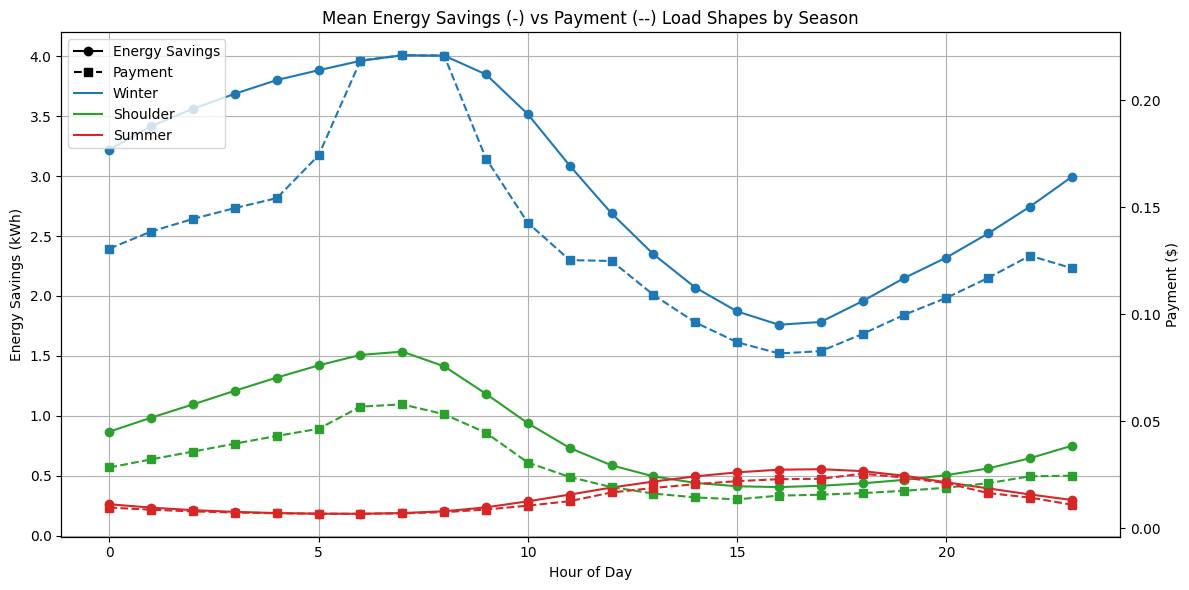

In [0]:
# try filtering to only homes with existing AC-- doesn't make much of a diff for the red curve
plot_mean_energy_and_payment_load_profiles_by_season(df_w_metadata[(df_w_metadata.upgrade_id==HP_UPGRADE_ID) & (df_w_metadata.in_hvac_cooling_type=='AC')].copy())

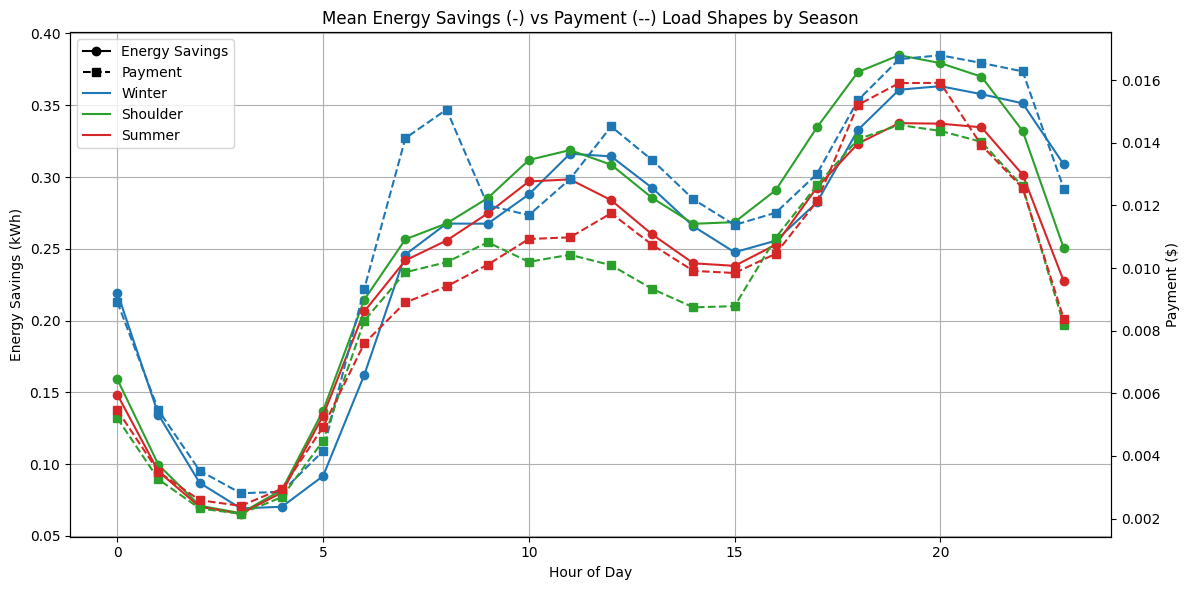

In [0]:
# look at same thing for hpwh (the seasonal variation isnt super meaningful here other than payment spike for winter mornings)
plot_mean_energy_and_payment_load_profiles_by_season(df_w_metadata[(df_w_metadata.upgrade_id==HPWH_UPGRADE_ID)].copy())


### Bar Charts
Finally we can look at typical household payments over the entire season/month/hour hour summed over the whole year to give us numbers at a scale we are more used to reasoning about with respect to energy bills.

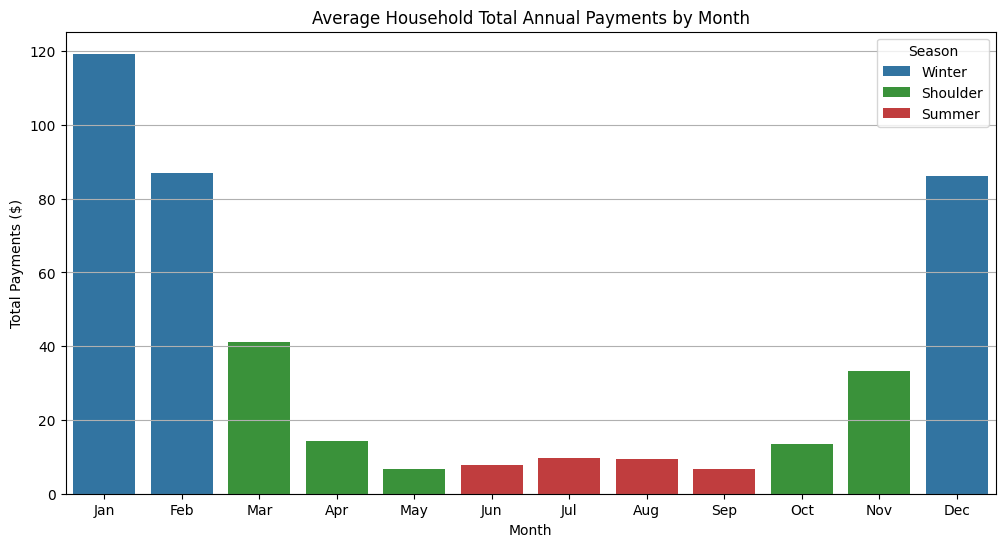

In [0]:
def prepare_seasonal_data(df, time_col, upgrade_id=HP_UPGRADE_ID):
    """Prepares seasonal payment data for plotting"""
    return (
        df[df.upgrade_id == upgrade_id]
        .groupby(['building_id', time_col, 'season'], as_index=False)
        .payment.sum()
        .groupby([time_col, 'season'], as_index=False)
        .payment.mean()
    )

# 1. Monthly payments plot with seasonal coloring
plt.figure(figsize=(12, 6))
sns.barplot(
    data=prepare_seasonal_data(df_w_metadata, 'month'),
    x='month',
    y='payment',
    hue='season',
    palette=SEASON_COLORS,
    dodge=False  # All bars in single column
)
plt.title('Average Household Total Annual Payments by Month')
plt.xlabel('Month')
plt.ylabel('Total Payments ($)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Season')
plt.grid(axis='y')
plt.show()



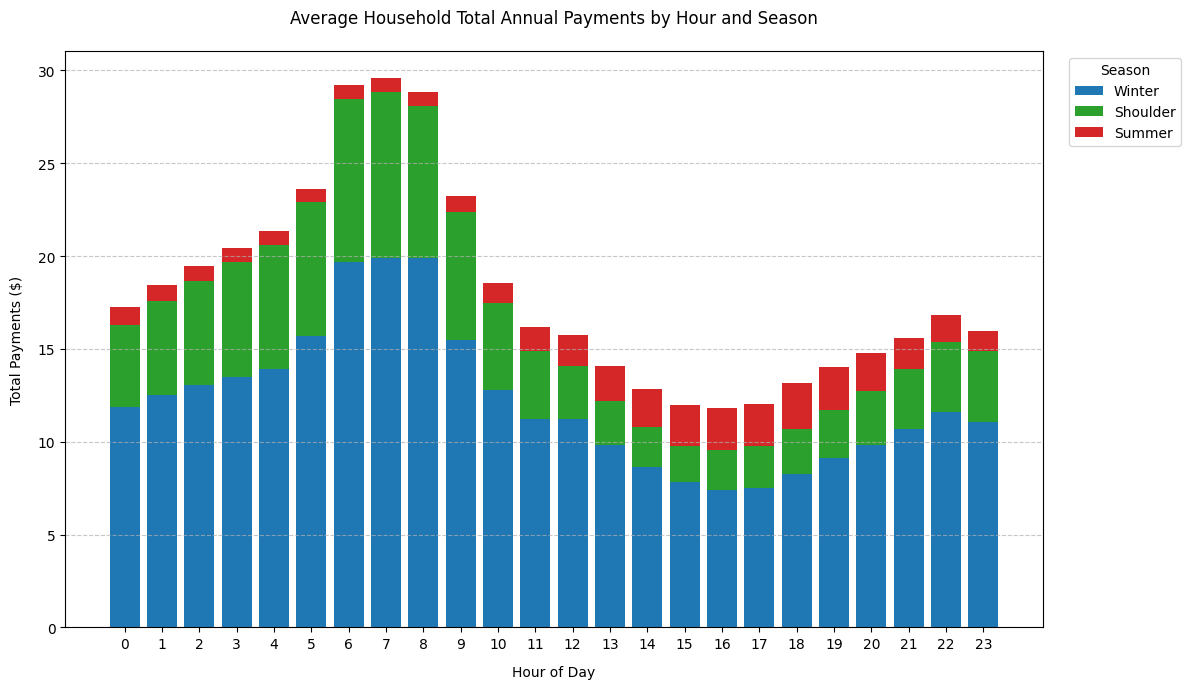

In [0]:
# Pivot for stacked bars
hourly_pivot = prepare_seasonal_data(df_w_metadata, 'hour').pivot(
    index='hour',
    columns='season',
    values='payment'
).fillna(0)

# Reorder seasons for logical stacking
season_order = list(SEASON_COLORS.keys())
hourly_pivot = hourly_pivot[season_order]

# 2. Hourly payments plot (stacked by season)
plt.figure(figsize=(12, 7))
bottom = None
for season in season_order:
    plt.bar(
        x=hourly_pivot.index,
        height=hourly_pivot[season],
        bottom=bottom,
        label=season,
        color=SEASON_COLORS[season],
        width=0.8
    )
    if bottom is None:
        bottom = hourly_pivot[season]
    else:
        bottom += hourly_pivot[season]

plt.title('Average Household Total Annual Payments by Hour and Season', pad=20)
plt.xlabel('Hour of Day', labelpad=10)
plt.ylabel('Total Payments ($)', labelpad=10)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(
    title='Season',
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()
